In [643]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
def plot_outliners(data, column):
    max_charge = data[column].max()
    min_charge = data[column].min()
    print(f"Maior valor de {column}: {max_charge}")
    print(f"Menor valor de {column}: {min_charge}")
    plt.boxplot(data[column])
    plt.title(column.capitalize() + ' Boxplot')
    plt.ylabel('Valores')
    plt.show()

def remove_outliers(df, column):
    plot_outliners(df , column)
    Q1, Q3 = np.percentile(df[column], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    
    print(f"Valores de {column} antes da remoção de outliers: {df[column].shape[0]}")
    print(f"Valores de {column} depois da remoção de outliers: {df[column].shape[0]}")
    print(f"Q1: {Q1}") # separa os 25% menores valores do conjunto de dados.
    print(f"Q3: {Q3}") # separa os 25% maiores valores do conjunto de dados.
    print(f"Limite Inferior: {lower_bound}")
    print(f"Limite Superior: {upper_bound}")
    print("------------------------")
    plot_outliners(df , column)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


def plot_chart_and_predict(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previsto')
    plt.title('Gráfico de Dispersão: Valores Reais vs Valores Previsto')
    plt.show()

    # Erros
    print("Erro Absoluto Médio (MAE):", mean_absolute_error(y_test, y_pred))
    print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
    print("Raiz do Erro Quadrático Médio (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAPE:", calculate_mape(y_test, y_pred), "%")
    print("R²:", r2_score(y_test, y_pred))


In [645]:
data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo
data.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,yes,16884.92400
1,18,33.770,1,no,1725.55230
2,28,33.000,3,no,4449.46200
3,33,22.705,0,no,21984.47061
4,32,28.880,0,no,3866.85520


In [646]:
data.isnull().sum()

age         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

In [647]:
numeric_columns = [ 'age', 'bmi', 'children']
for numeric_collumn in numeric_columns:
    pass #remove_outliers(data, numeric_collumn)


In [648]:
data.isnull().sum()

age         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

<Axes: >

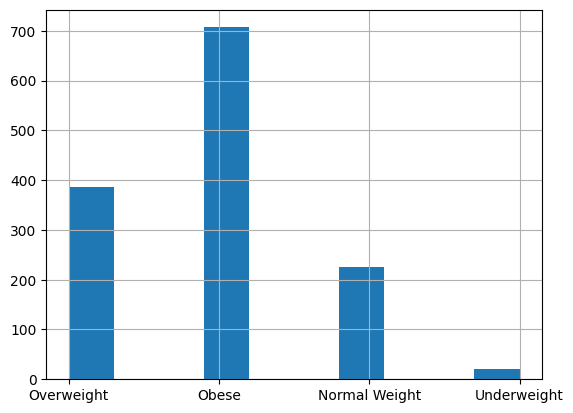

In [649]:
# Aplicando a Obesidade
# https://www.cancer.org/cancer/risk-prevention/diet-physical-activity/body-weight-and-cancer-risk.html
# IMC entre 25,0 e 29,9 Kg/m2: sobrepeso; 
# IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I; 
# IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II; 
# IMC maior do que 40,0 Kg/m2: obesidade grau III.
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"

data["weight_condition"].hist()


In [650]:
# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns), # numeric features
        ('cat', OneHotEncoder(), categorical_columns) # categorical features
    ])


base_transformed = preprocessor.fit_transform(data)
base_transformed


array([[-1.43876426, -0.45332   , -0.90861367, ...,  0.        ,
         1.        ,  0.        ],
       [-1.50996545,  0.5096211 , -0.07876719, ...,  1.        ,
         0.        ,  0.        ],
       [-0.79795355,  0.38330685,  1.58092576, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367, ...,  1.        ,
         0.        ,  0.        ],
       [-1.29636188, -0.79781341, -0.90861367, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.55168573, -0.26138796, -0.90861367, ...,  0.        ,
         1.        ,  0.        ]])

In [651]:

base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()


,charges,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,1725.55230,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,4449.46200,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,21984.47061,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,3866.85520,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


charges                                1.000000
cat__smoker_yes                        0.787251
num__age                               0.299008
cat__weight_condition_Obese            0.199532
num__bmi                               0.198341
num__children                          0.067998
cat__weight_condition_Underweight     -0.044960
cat__weight_condition_Normal Weight   -0.106265
cat__weight_condition_Overweight      -0.120083
cat__smoker_no                        -0.787251
Name: charges, dtype: float64


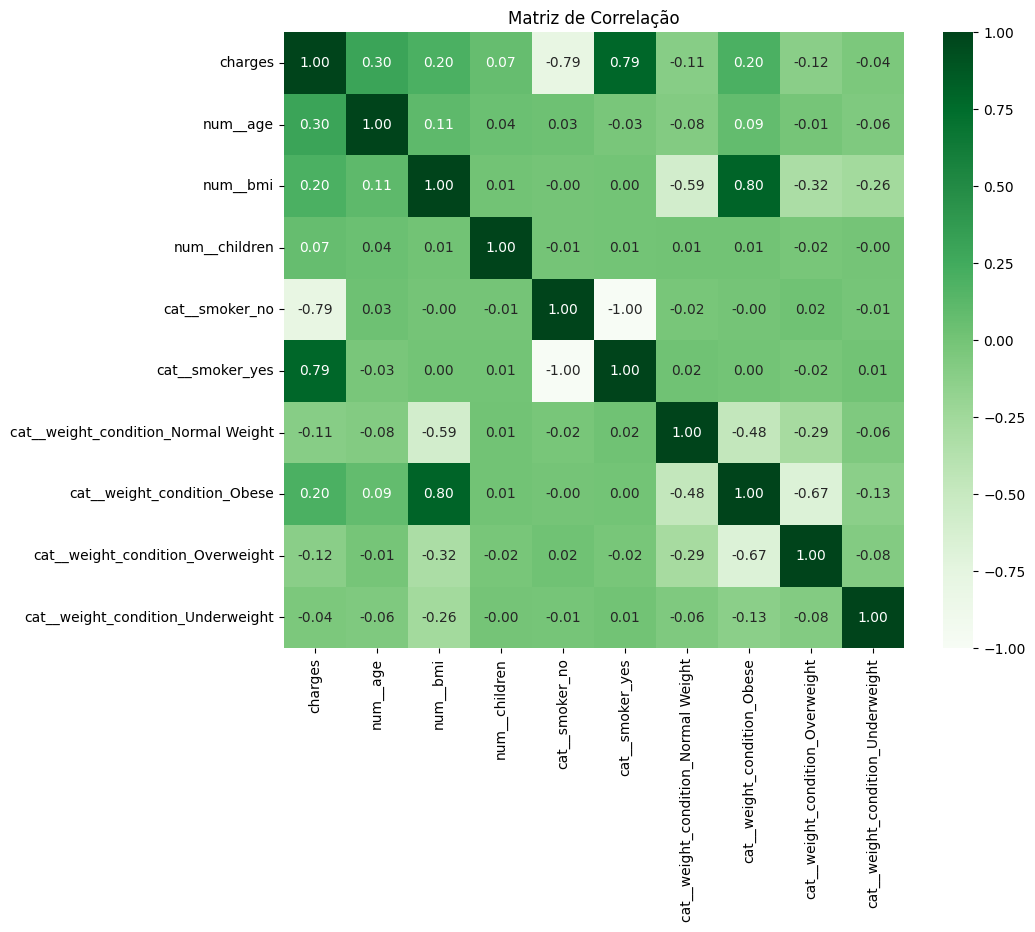

In [652]:
# Matriz de correlação
correlation_matrix = data.corr()
print(correlation_matrix["charges"].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [653]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train

,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
515,1.338082,0.826227,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
285,0.483668,-0.663297,-0.078767,1.0,0.0,0.0,0.0,1.0,0.0
1129,-1.438764,-1.978934,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
71,-0.584350,-0.354893,3.240619,1.0,0.0,0.0,0.0,1.0,0.0
561,1.053277,0.330813,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
763,-0.869155,-0.760083,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0
835,0.198863,0.870519,0.751079,1.0,0.0,0.0,1.0,0.0,0.0
1216,0.056461,-0.915925,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0
559,-1.438764,0.798339,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0


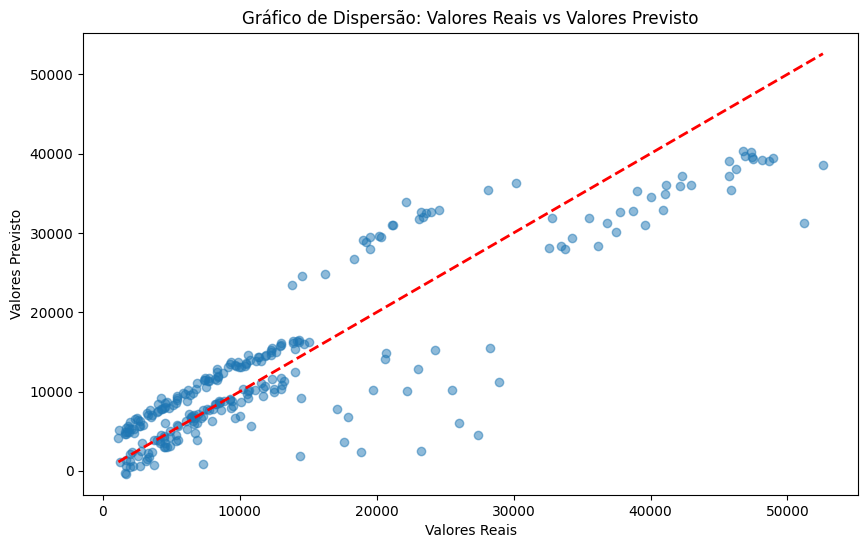

Erro Absoluto Médio (MAE): 4101.795298155493
Erro Quadrático Médio (MSE): 32288223.845232174
Raiz do Erro Quadrático Médio (RMSE): 5682.272771104197
MAPE: 45.224109834077154 %
R²: 0.7970952586548637


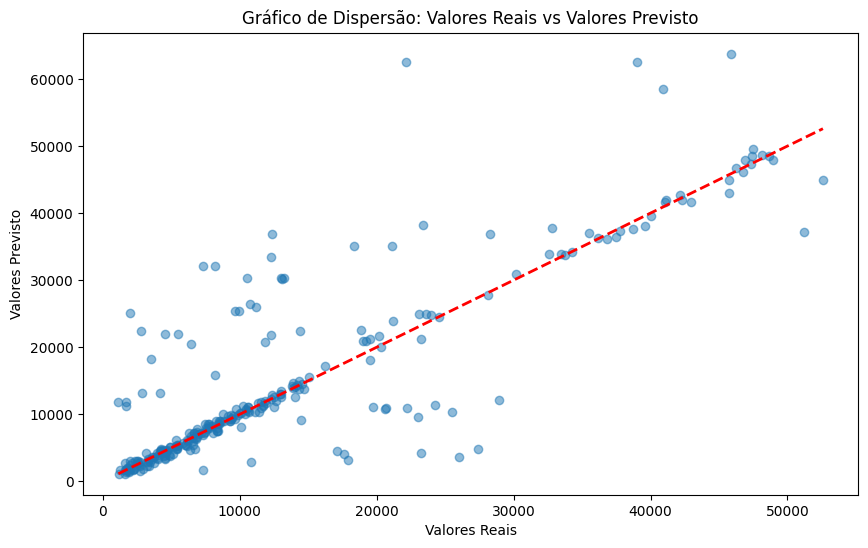

Erro Absoluto Médio (MAE): 3523.4877484664175
Erro Quadrático Médio (MSE): 54040616.339971855
Raiz do Erro Quadrático Médio (RMSE): 7351.232300775962
MAPE: 44.19040365199857 %
R²: 0.6603994901313568


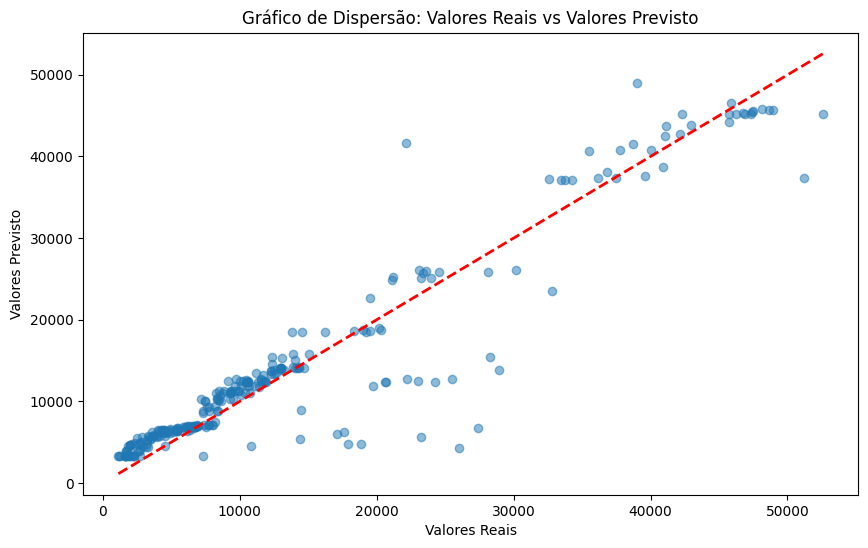

Erro Absoluto Médio (MAE): 2530.0841228899985
Erro Quadrático Médio (MSE): 17680601.15126391
Raiz do Erro Quadrático Médio (RMSE): 4204.83069234231
MAPE: 31.785317059884587 %
R²: 0.8888920672558622


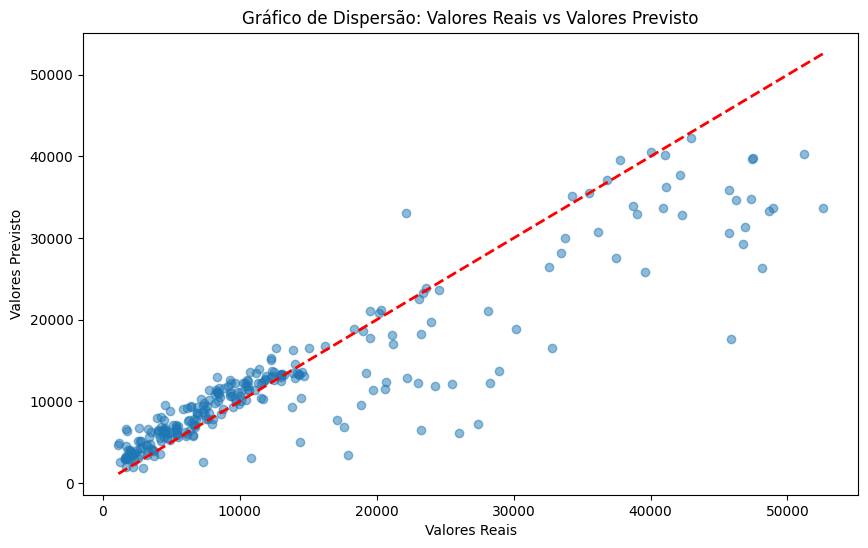

Erro Absoluto Médio (MAE): 3380.597191393657
Erro Quadrático Médio (MSE): 31921740.207133614
Raiz do Erro Quadrático Médio (RMSE): 5649.932761293147
MAPE: 34.47814836344405 %
R²: 0.7993983047484504


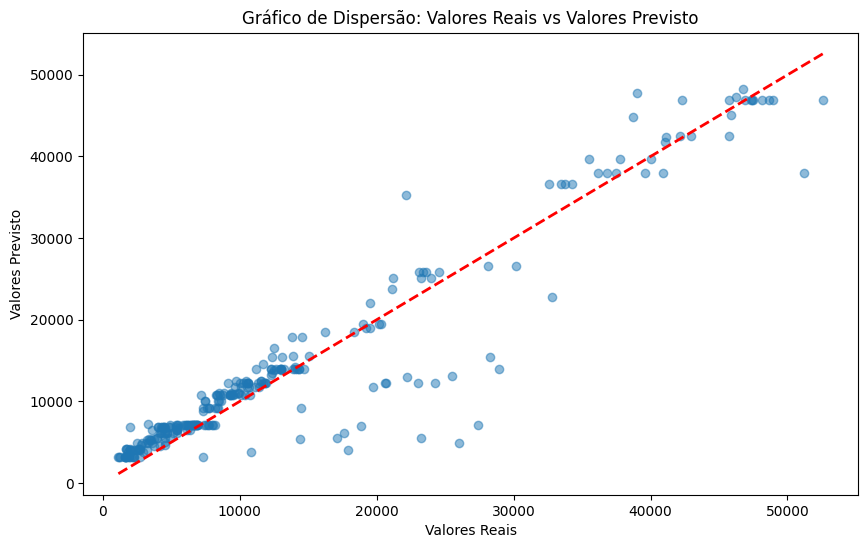

Erro Absoluto Médio (MAE): 2424.082151911104
Erro Quadrático Médio (MSE): 16362219.357660415
Raiz do Erro Quadrático Médio (RMSE): 4045.0240243613407
MAPE: 30.50796536395063 %
R²: 0.8971770047645804


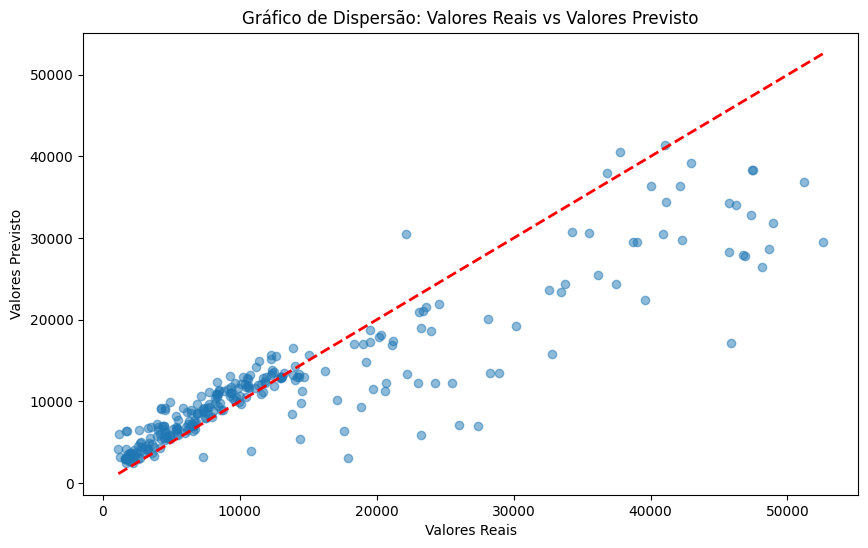

Erro Absoluto Médio (MAE): 3752.645156435074
Erro Quadrático Médio (MSE): 38149887.440120205
Raiz do Erro Quadrático Médio (RMSE): 6176.559514820545
MAPE: 35.52102714509371 %
R²: 0.760259558392318


In [654]:


models = [
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=200, 
                          max_depth=18, max_leaf_nodes=12,
                          criterion = 'friedman_mse',
                          random_state = 1,
                          n_jobs = -1),
    KNeighborsRegressor(n_neighbors=20),
    RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1),
    KNeighborsRegressor(n_neighbors=25)
]
for model in models:
    plot_chart_and_predict(model, X_test_clean, X_train_clean, y_test_clean, y_train_clean)